In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa 
import librosa.display
from IPython.display import Audio
import warnings 
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout

In [2]:
paths=[]
labels=[]
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename[::-1].split('_')[0][::-1]
        labels.append(label.lower())

data = pd.DataFrame({'speech':paths,'label':labels})
data.sample(5)

,speech,label
5425,/kaggle/input/toronto-emotional-speech-set-tes...,ps.wav
849,/kaggle/input/toronto-emotional-speech-set-tes...,neutral.wav
3059,/kaggle/input/toronto-emotional-speech-set-tes...,angry.wav
1733,/kaggle/input/toronto-emotional-speech-set-tes...,neutral.wav
2745,/kaggle/input/toronto-emotional-speech-set-tes...,ps.wav


In [3]:
data['label'].value_counts()

fear.wav       800
angry.wav      800
disgust.wav    800
neutral.wav    800
sad.wav        800
ps.wav         800
happy.wav      800
Name: label, dtype: int64

In [4]:
def waveplot(data,sr,emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion,size=20)
    librosa.display.waveshow(data,sr=sr)
    plt.show()
    
def spectogram(data,sr,emotion):
    x=librosa.stft(data)
    xdb=librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    librosa.display.specshow(xdb,sr=sr,x_axis='time',y_axis='hz')
    plt.colorbar()
    
def ana_emotion(emotion:str, df:pd.DataFrame):
    path=np.array(df['speech'][df['label']==emotion])[0]
    data,sampling_rate=librosa.load(path)
    waveplot(data,sampling_rate,emotion)
    spectogram(data,sampling_rate,emotion)
    display(Audio(path))

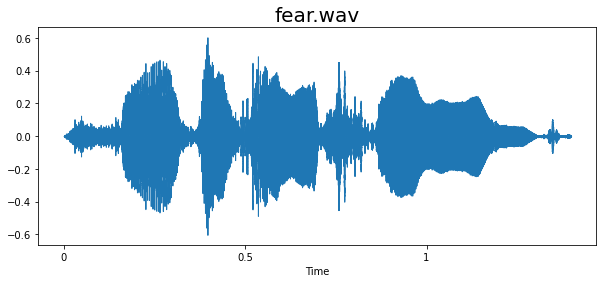

None

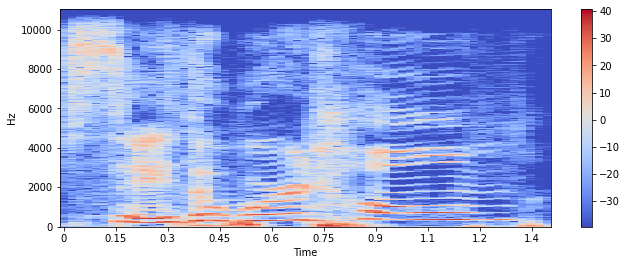

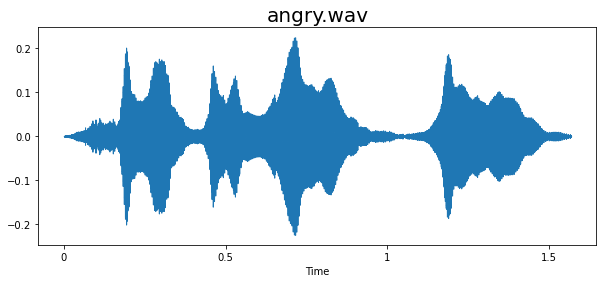

None

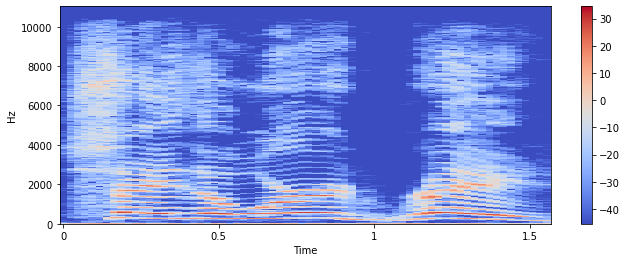

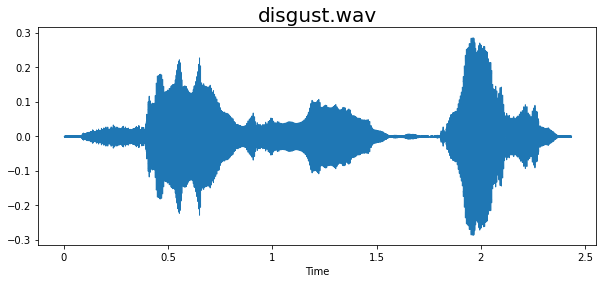

None

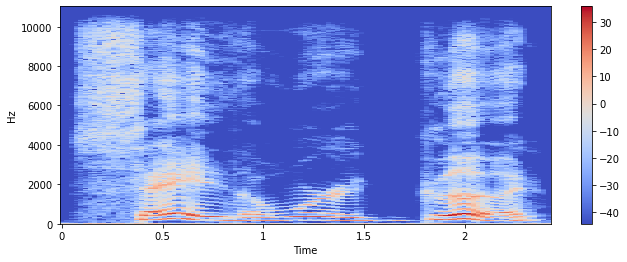

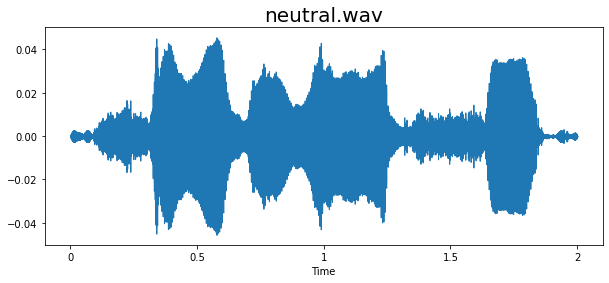

None

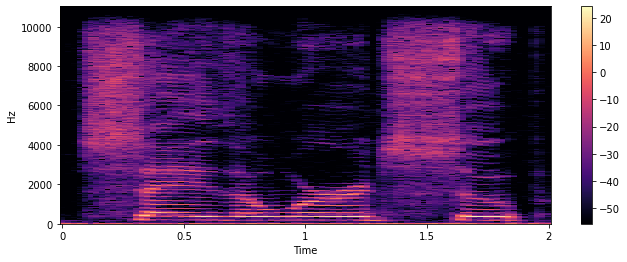

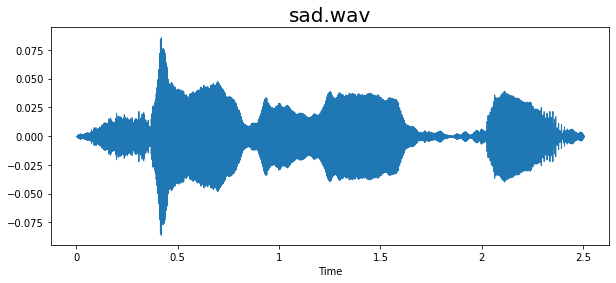

None

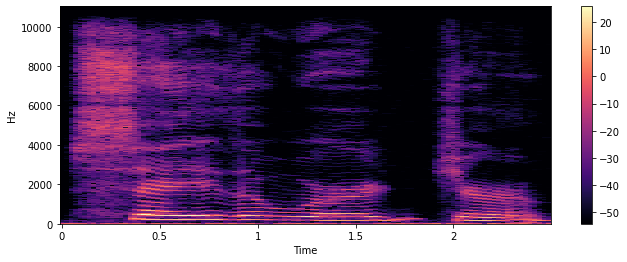

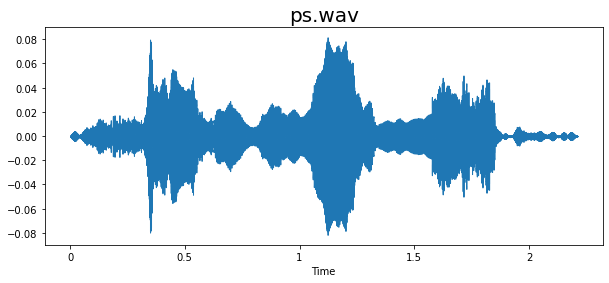

None

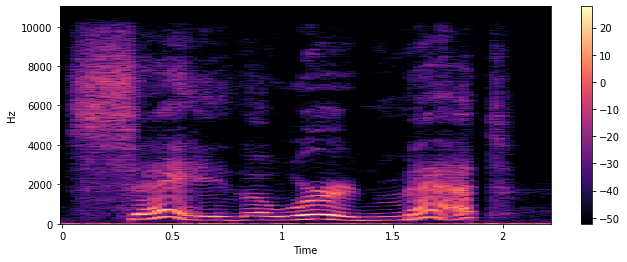

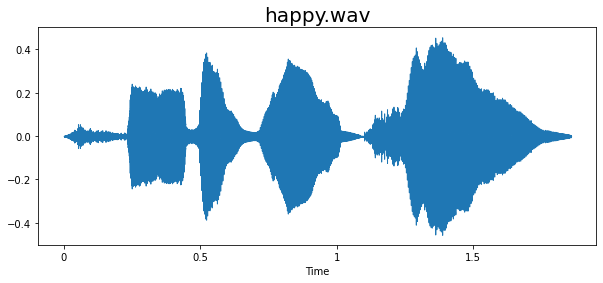

None

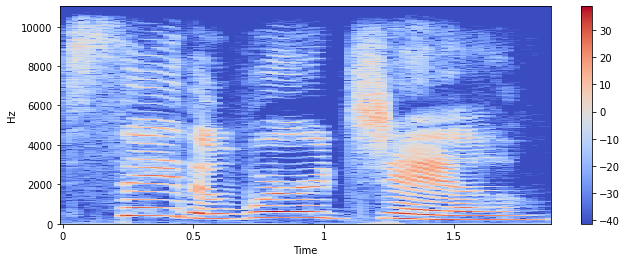

In [5]:
for i in list(data['label'].unique()):
    display(ana_emotion(i, data))

## Read this resource 
## [MFCC & PLP](https://jonathan-hui.medium.com/speech-recognition-feature-extraction-mfcc-plp-5455f5a69dd9)

In [6]:
def MFCC(filename):
    y, sr = librosa.load(filename,duration=3,offset=0.5)
    return np.mean(librosa.feature.mfcc(y=y,sr=sr,n_mfcc=40).T,axis=0)

mfcc= data['speech'].apply(lambda x:MFCC(x))

In [7]:
mfcc

0       [-287.13037, 87.756935, -4.139177, 24.081968, ...
1       [-350.0836, 37.654167, -6.2928553, 17.09615, 4...
2       [-341.78152, 56.153652, -16.617884, 23.219698,...
3       [-309.17456, 24.854897, -8.00109, 10.065497, -...
4       [-347.12918, 49.69155, -27.524876, 22.730288, ...
                              ...                        
5595    [-376.5839, 63.9598, -3.0598662, 11.498796, -2...
5596    [-316.5801, 43.54606, -9.336959, -0.198444, -5...
5597    [-359.7638, 81.01536, -18.355762, 5.3012295, -...
5598    [-354.38315, 103.432144, -15.916284, -10.30884...
5599    [-391.15958, 56.44471, -1.0464002, 0.9587419, ...
Name: speech, Length: 5600, dtype: object

In [8]:
X=[x for x in mfcc]
X=np.array(X)
X.shape
X=np.expand_dims(X,-1)
X.shape

(5600, 40, 1)

In [9]:
ohe=OneHotEncoder()
y = ohe.fit_transform( data[['label']] )
y= y.toarray()

In [10]:
model=Sequential([
    LSTM(256,return_sequences=False,input_shape=(40,1)),
    Dense(128,activation='relu'),
    Dropout(0.2),
    Dense(64,activation='relu'),
    Dropout(0.2),
    Dense(7,activation='softmax')
])

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

2022-10-26 05:34:01.029948: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 05:34:01.030942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 05:34:01.347738: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 05:34:01.348682: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 05:34:01.349553: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               264192    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 455       
Total params: 305,799
Trainable params: 305,799
Non-trainable params: 0
__________________________________________________

In [11]:
#Train the model
history=model.fit(X,y,validation_split=0.2,epochs=50,batch_size=64)

2022-10-26 05:34:07.752019: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-10-26 05:34:11.219981: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


70/70 [==============================] - 8s 17ms/step - loss: 0.7866 - accuracy: 0.7228 - val_loss: 0.4673 - val_accuracy: 0.8366
Epoch 2/50
70/70 [==============================] - 0s 6ms/step - loss: 0.2048 - accuracy: 0.9348 - val_loss: 0.1869 - val_accuracy: 0.9375
Epoch 3/50
70/70 [==============================] - 0s 6ms/step - loss: 0.1371 - accuracy: 0.9576 - val_loss: 0.0749 - val_accuracy: 0.9741
Epoch 4/50
70/70 [==============================] - 1s 10ms/step - loss: 0.1268 - accuracy: 0.9614 - val_loss: 0.0727 - val_accuracy: 0.9741
Epoch 5/50
70/70 [==============================] - 0s 6ms/step - loss: 0.1014 - accuracy: 0.9692 - val_loss: 0.1901 - val_accuracy: 0.9330
Epoch 6/50
70/70 [==============================] - 0s 6ms/step - loss: 0.1061 - accuracy: 0.9654 - val_loss: 0.2453 - val_accuracy: 0.9241
Epoch 7/50
70/70 [==============================] - 0s 6ms/step - loss: 0.0820 - accuracy: 0.9746 - val_loss: 0.0540 - val_accuracy: 0.9795
Epoch 8/50
70/70 [===========

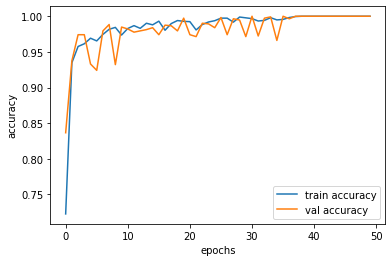

In [12]:
epochs = list(range(50))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()